In [18]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: C:\Users\makar\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
train = pd.read_csv('Titanic.csv')
test = pd.read_csv('test.csv')

Посмотрим на данные

In [20]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


В данных есть пропуски

In [22]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Объединим test и train данные для удобного feature engineering

In [23]:
train['TrainFlag'] = 1
test['TrainFlag'] = 0
test['Survived'] = np.nan
full_data = pd.concat([train, test], sort=False).reset_index(drop=True)

Уберем пропуски и добавим несколько новых признаков:

Family - количество родственников на корабле(включая самого себя)

IsAlone - признак, показывающий есть ли родственники на корабле

Title - Приставка перед именем человека (Mr, Miss, Mrs)

CabinDeck - Часть корабля в которой находится каюта пассажира


In [24]:
full_data['Age'] = full_data['Age'].fillna(full_data.groupby('Pclass')['Age'].transform('median'))
full_data['Fare'] = full_data['Fare'].fillna(full_data['Fare'].median())
full_data['Embarked'] = full_data['Embarked'].fillna(full_data['Embarked'].mode()[0])
full_data['FamilySize'] = full_data['SibSp'] + full_data['Parch'] + 1
full_data['IsAlone'] = (full_data['FamilySize'] == 1).astype(int)
full_data['Title'] = full_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
full_data['Cabin'] = full_data['Cabin'].fillna('U') # заменим неизвестные типы кабин на U
full_data['CabinDeck'] = full_data['Cabin'].apply(lambda x: x[0])
title_counts = full_data['Title'].value_counts()
title_counts

<>:6: SyntaxWarning: invalid escape sequence '\.'
<>:6: SyntaxWarning: invalid escape sequence '\.'
C:\Users\makar\AppData\Local\Temp\ipykernel_24600\2322144867.py:6: SyntaxWarning: invalid escape sequence '\.'
  full_data['Title'] = full_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)


Title
Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Mlle          2
Major         2
Ms            2
Lady          1
Sir           1
Mme           1
Don           1
Capt          1
Countess      1
Jonkheer      1
Dona          1
Name: count, dtype: int64

Заменим редкие приставки перед именами на Rare

In [25]:
full_data['Title'] = full_data['Title'].replace(title_counts[title_counts < 50].index, 'Rare')
full_data['Embarked'] = full_data['Embarked'].astype(str)
full_data['Title'] = full_data['Title'].astype(str)
full_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,TrainFlag,FamilySize,IsAlone,Title,CabinDeck
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,U,S,1,2,0,Mr,U
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,2,0,Mrs,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,U,S,1,1,1,Miss,U
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,2,0,Mrs,C
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,U,S,1,1,1,Mr,U
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,24.0,0,0,A.5. 3236,8.0500,U,S,0,1,1,Mr,U
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,0,1,1,Rare,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,U,S,0,1,1,Mr,U
1307,1308,NaN,3,"Ware, Mr. Frederick",male,24.0,0,0,359309,8.0500,U,S,0,1,1,Mr,U


In [26]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1309 non-null   float64
 10  Cabin        1309 non-null   object 
 11  Embarked     1309 non-null   object 
 12  TrainFlag    1309 non-null   int64  
 13  FamilySize   1309 non-null   int64  
 14  IsAlone      1309 non-null   int32  
 15  Title        1309 non-null   object 
 16  CabinDeck    1309 non-null   object 
dtypes: float64(3), int32(1), int64(6), object(7)
memory usage: 168.9+ KB


Выделим числовые и категориальные признаки

In [27]:
numeric_features = ['Age', 'Fare', 'FamilySize']
categorical_features = ['Pclass', 'Sex', 'Embarked', 'IsAlone', 'Title','CabinDeck']

Разделим данные обратно после feature engineering

Выведем получившийся X_train и X_test

In [28]:
features = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'FamilySize', 'IsAlone', 'Title','CabinDeck']
X_all = full_data[features]
X_train = X_all[full_data['TrainFlag'] == 1]
X_test = X_all[full_data['TrainFlag'] == 0].reset_index().drop('index', axis=1)
X_train['Survived'] = full_data.loc[full_data['TrainFlag'] == 1, 'Survived'].astype(int)
X_train

C:\Users\makar\AppData\Local\Temp\ipykernel_24600\4038756026.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Survived'] = full_data.loc[full_data['TrainFlag'] == 1, 'Survived'].astype(int)


,Pclass,Sex,Age,Fare,Embarked,FamilySize,IsAlone,Title,CabinDeck,Survived
0,3,male,22.0,7.2500,S,2,0,Mr,U,0
1,1,female,38.0,71.2833,C,2,0,Mrs,C,1
2,3,female,26.0,7.9250,S,1,1,Miss,U,1
3,1,female,35.0,53.1000,S,2,0,Mrs,C,1
4,3,male,35.0,8.0500,S,1,1,Mr,U,0
...,...,...,...,...,...,...,...,...,...,...
886,2,male,27.0,13.0000,S,1,1,Rare,U,0
887,1,female,19.0,30.0000,S,1,1,Miss,B,1
888,3,female,24.0,23.4500,S,4,0,Miss,U,0
889,1,male,26.0,30.0000,C,1,1,Mr,C,1


In [29]:
X_test

,Pclass,Sex,Age,Fare,Embarked,FamilySize,IsAlone,Title,CabinDeck
0,3,male,34.5,7.8292,Q,1,1,Mr,U
1,3,female,47.0,7.0000,S,2,0,Mrs,U
2,2,male,62.0,9.6875,Q,1,1,Mr,U
3,3,male,27.0,8.6625,S,1,1,Mr,U
4,3,female,22.0,12.2875,S,3,0,Mrs,U
...,...,...,...,...,...,...,...,...,...
413,3,male,24.0,8.0500,S,1,1,Mr,U
414,1,female,39.0,108.9000,C,1,1,Rare,C
415,3,male,38.5,7.2500,S,1,1,Mr,U
416,3,male,24.0,8.0500,S,1,1,Mr,U


Выведем гистограммы по всем признакам

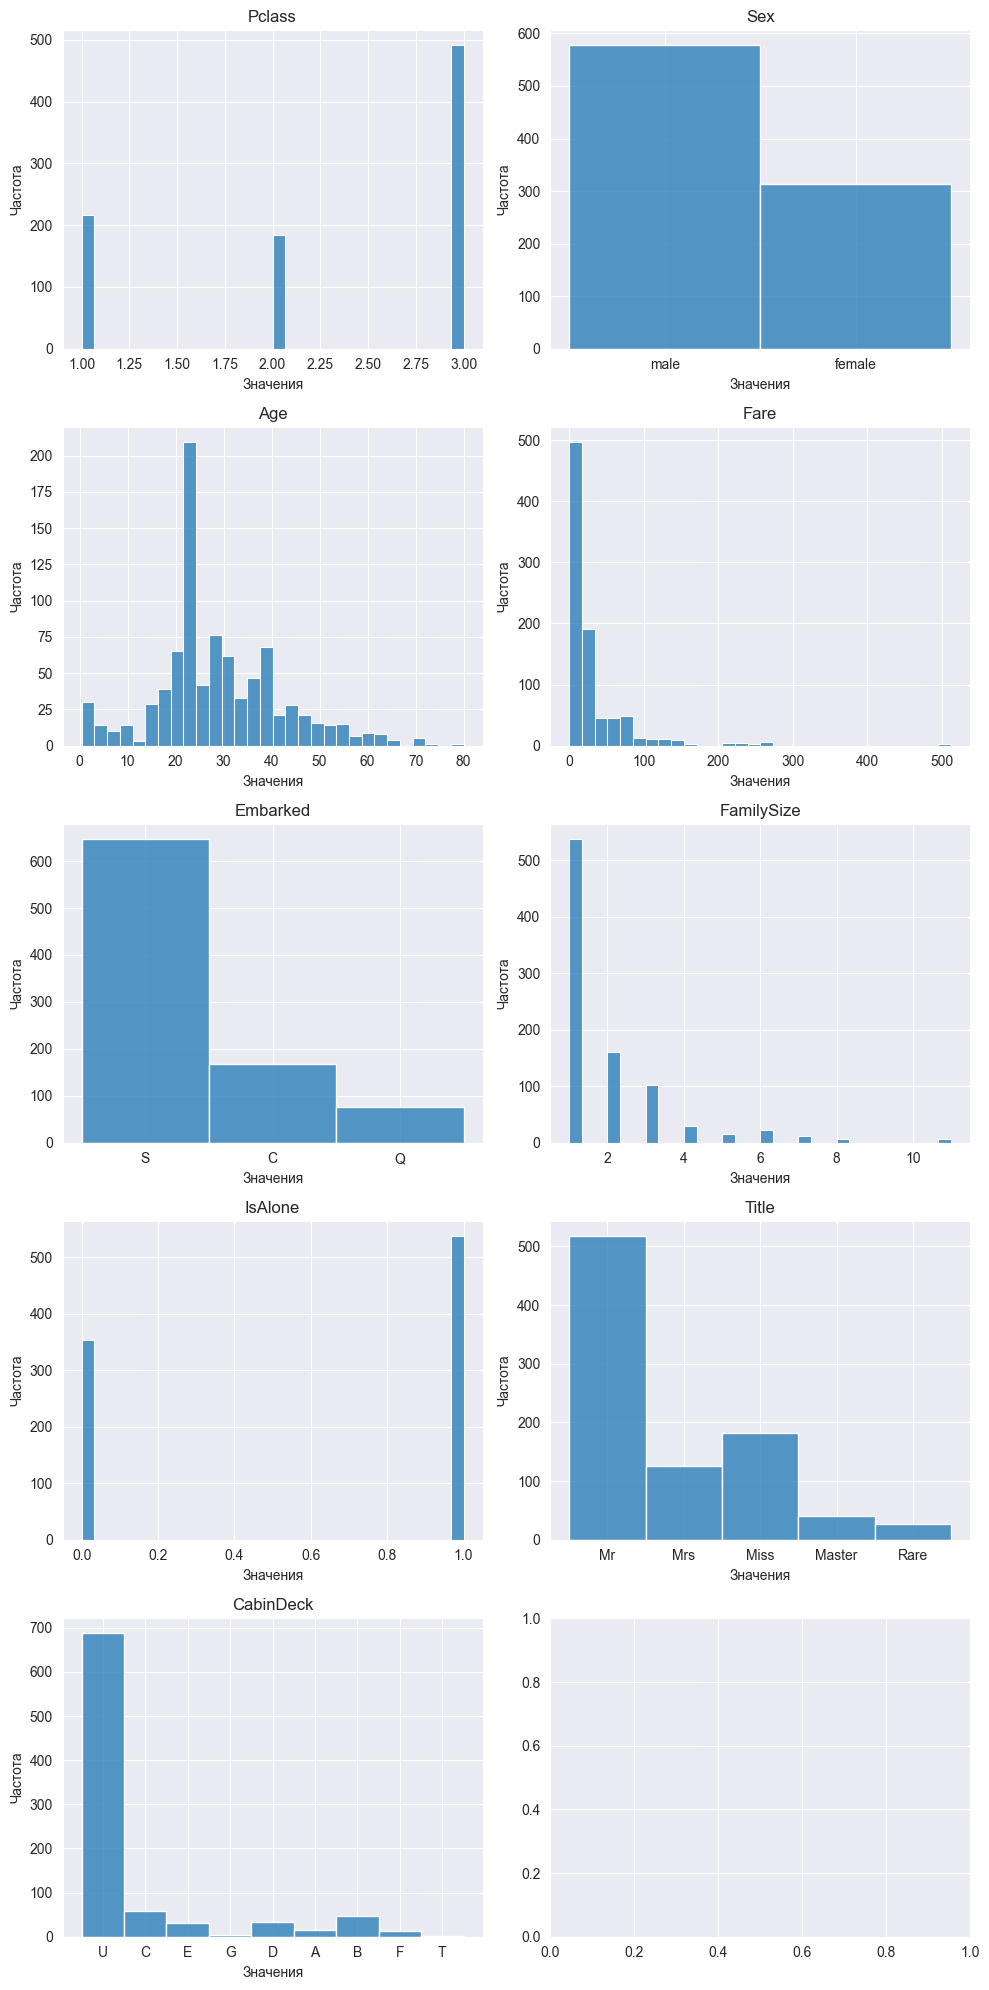

In [30]:
width = 2
height = int(np.ceil(len(features) / width))

fig, axes = plt.subplots(nrows=height, ncols=width, figsize=(10, 4 * height))
axes = axes.flatten()

for idx, column in enumerate(features):
    sns.histplot(data=X_train, x=column, bins=30, ax=axes[idx])
    axes[idx].set_title(column)
    axes[idx].set_xlabel('Значения')
    axes[idx].set_ylabel('Частота')

plt.tight_layout()
plt.show()

Age имеет нормальное распределение, Fare, FamilySize имеют экспоненциальное распределения

Стандартизируем числовые признаки и закодируем категориальные для X_train

In [31]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore',sparse_output=False), categorical_features)
    ]
)

In [32]:
y = X_train["Survived"]

X_train_transformed = preprocessor.fit_transform(X_train)
ohe = preprocessor.named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numeric_features, cat_feature_names])
X_train_transformed = pd.DataFrame(X_train_transformed, columns=all_feature_names)
X_train_transformed['Survived'] = y
X_train_transformed

,Age,Fare,FamilySize,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,...,CabinDeck_A,CabinDeck_B,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T,CabinDeck_U,Survived
0,-0.537087,-0.502445,0.059160,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
1,0.667524,0.786845,0.059160,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,-0.235934,-0.488854,-0.560975,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
3,0.441659,0.420730,0.059160,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.441659,-0.486337,-0.560975,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,-0.160646,-0.386671,-0.560975,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
887,-0.762952,-0.044381,-0.560975,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
888,-0.386511,-0.176263,1.299429,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
889,-0.235934,-0.044381,-0.560975,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1


То же самое сделаем для X_test

In [33]:
X_test_transformed = preprocessor.transform(X_test)
ohe = preprocessor.named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numeric_features, cat_feature_names])
X_test_transformed = pd.DataFrame(X_test_transformed, columns=all_feature_names)
X_test_transformed

,Age,Fare,FamilySize,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,...,Title_Rare,CabinDeck_A,CabinDeck_B,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T,CabinDeck_U
0,0.404015,-0.490783,-0.560975,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.345118,-0.507479,0.059160,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2.474441,-0.453367,-0.560975,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.160646,-0.474005,-0.560975,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.537087,-0.401017,0.679295,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,-0.386511,-0.486337,-0.560975,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
414,0.742812,1.544246,-0.560975,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
415,0.705168,-0.502445,-0.560975,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
416,-0.386511,-0.486337,-0.560975,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Выведем корреляционную матрицу для всех признаков

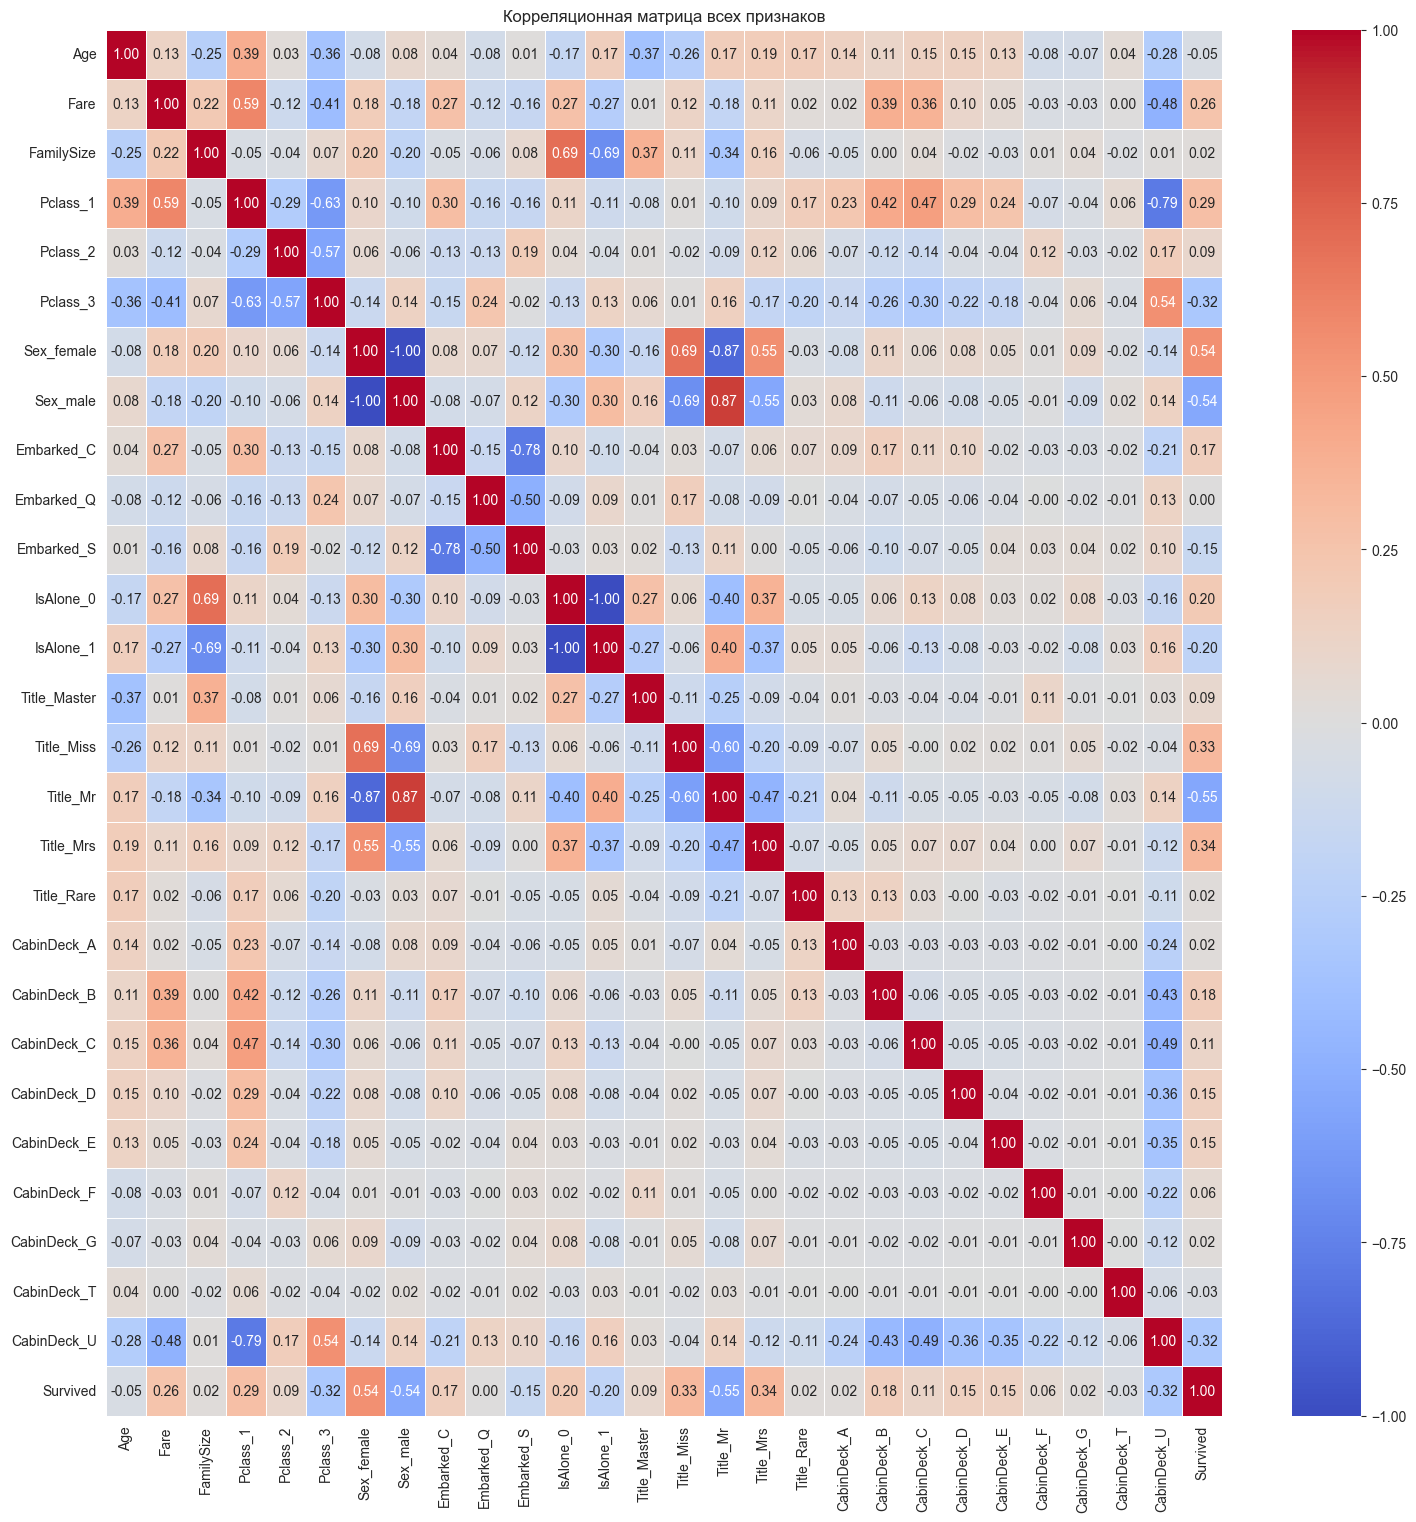

In [34]:
corr_matrix = X_train_transformed.corr()

plt.figure(figsize=(18, 18))
sns.heatmap(corr_matrix,  cmap='coolwarm', linewidths=0.5,annot=True,fmt='.2f')
plt.title('Корреляционная матрица всех признаков')
plt.show()


Основные корреляции с target('Survived')

Sex_female 0.54 - женщин выжило больше, чем мужчин (для Sex_male корреляция -0.54)

Fare - чем дороже билет, тем выше вероятность выживания

Pclass1 - чем выше класс каюты, тем выше вероятность выживания (для Pclass3 корреляция -0.32)

Title_Miss и Title_Mrs 0.33 и 0.34 - так как сильная корреляция с полом, то и здесь тоже (для Title_Mr -0.55)

Embarked_C - те кто сели на Титаник в Cherbourg с большей вероятностью выжили

IsAlone0 - 0.20 те у кого на корабле были родственики с большей вероятностью выжили

Также есть слабые корреляции с расположением каюты

Выведем отдельно значения всех корреляций с target

In [19]:

surv_corr = X_train_transformed.corr()['Survived'].sort_values(ascending=False).drop('Survived', axis=0)

print(" Корреляция признаков с выживанием:")
X_train_transformed = X_train_transformed.drop('Survived', axis=1)
surv_corr

 Корреляция признаков с выживанием:


Title_Mrs       0.074296
Sex_female      0.067468
Pclass_2        0.066593
Embarked_C      0.048863
Fare            0.042361
IsAlone_0       0.020389
Title_Rare      0.013623
FamilySize      0.013430
Pclass_1        0.008311
Embarked_Q      0.005664
Title_Miss     -0.000386
Age            -0.015364
IsAlone_1      -0.020389
Title_Mr       -0.040027
Title_Master   -0.043790
Embarked_S     -0.046898
Pclass_3       -0.061711
Sex_male       -0.067468
Name: Survived, dtype: float64

In [35]:
X_train_, X_val_, y_train_, y_val = train_test_split(
     X_train_transformed, y, test_size=0.2, stratify=y, random_state=42
)

Создадим несколько моделей и варианты параметров

In [20]:
models = [
    ("LogisticRegression", LogisticRegression(max_iter=1000,random_state=42, solver='liblinear')),
    ("RandomForest", RandomForestClassifier(n_estimators=100, random_state=42,max_depth=8)),
    ("GradientBoosting", GradientBoostingClassifier(n_estimators=100, random_state=42,max_depth=4)),
    ("SVC", SVC(probability=True,random_state=42)),
    ("KNN", KNeighborsClassifier(n_neighbors=5)),
    ("XGBoost", XGBClassifier(colsample_bylevel= 0.7, colsample_bytree= 0.8, learning_rate= 0.05, max_depth= 5, min_child_weight= 5, n_estimators= 200, scale_pos_weight= 1, subsample= 0.8 )),
]


In [21]:
param_grids = {
    "LogisticRegression": {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'saga'],
        'penalty': ['l2', 'elasticnet'],
        'max_iter': [100, 500, 1000],
        'tol': [1e-4, 1e-3, 1e-2],
    },
    "RandomForest": {
        'n_estimators': [100, 200, 500],
        'max_depth': [8, 10, 12, 15],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
    },
    "GradientBoosting": {
        'n_estimators': [100, 200],
        'max_depth': [3, 4, 5,],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.8, 0.9, 1.0],
        'min_samples_split': [2,3,4, 5],
        'min_samples_leaf': [1, 2],
    },
    "SVC": {
        'C': [0.01, 0.1, 1],
        'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        'gamma': ['scale', 'auto', 0.1],
        'degree': [2, 3, 4],
        'class_weight': ['balanced', None],
    },
    "KNN": {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['minkowski', 'euclidean', 'manhattan'],
        'leaf_size': [20, 30, 40],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    },
    "XGBoost": {
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [100, 200],
        'max_depth': [4,5],
        'min_child_weight': [1, 3, 5, 7],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.7,0.8],
        'colsample_bylevel': [0.7],
        'scale_pos_weight': [1, 2],
    },
}

Для каждой модели используем GridSearchCV и StratifiedKFold для поиска лучших параметров по метрике accuracy(Потому что такая в соревновании на kaggle)

Для каждой модели выведем лучшие подобранные параметры

In [22]:
target=X_train['Survived']

results = {}
for name, model in models:
    print(f"Ищем лучшие параметры для модели: {name}")

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_train_transformed, y_train_)

    best_score = grid_search.best_score_
    best_params = grid_search.best_params_

    results[name] = best_score
    print(f"{name}: Accuracy = {best_score:.4f} (Лучшие параметры: {best_params})\n")

best_model_name = max(results, key=results.get)

print(f"\n Лучшая модель: {best_model_name}")


Ищем лучшие параметры для модели: LogisticRegression
Fitting 5 folds for each of 180 candidates, totalling 900 fits


C:\Users\makar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
450 fits failed out of a total of 900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
225 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\makar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\makar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-p

LogisticRegression: Accuracy = 0.8203 (Лучшие параметры: {'C': 10, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001})

Ищем лучшие параметры для модели: RandomForest
Fitting 5 folds for each of 108 candidates, totalling 540 fits
RandomForest: Accuracy = 0.8316 (Лучшие параметры: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200})

Ищем лучшие параметры для модели: GradientBoosting
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
GradientBoosting: Accuracy = 0.8316 (Лучшие параметры: {'learning_rate': 0.05, 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200, 'subsample': 1.0})

Ищем лучшие параметры для модели: SVC
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
SVC: Accuracy = 0.8329 (Лучшие параметры: {'C': 0.1, 'class_weight': None, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'})

Ищем лучшие параметры для модели: KNN
Fitting 5 folds for each of 288 candidates, t

C:\Users\makar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
6 fits failed out of a total of 2880.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\makar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\makar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-pack

XGBoost: Accuracy = 0.8301 (Лучшие параметры: {'colsample_bylevel': 0.7, 'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 7, 'n_estimators': 200, 'scale_pos_weight': 2, 'subsample': 0.9})


 Лучшая модель: SVC


В итоге лучшая модель XGBoost

XGBoost: Accuracy = 0.8329 (Лучшие параметры: {'colsample_bylevel': 0.7, 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 200, 'scale_pos_weight': 1, 'subsample': 0.8})

In [27]:
best_model = GradientBoostingClassifier(learning_rate= 0.01, max_depth= 4, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 100, subsample= 1.0 )
best_model.fit(
    X_train_transformed, y_train_,
)
predictions = best_model.predict(X_test_transformed)

Посмотрим есть ли переобучение на X_train

In [28]:
from sklearn.metrics import accuracy_score, roc_auc_score
predictions_val = best_model.predict(X_val_)
print(f"Train accuracy: {accuracy_score(y_val, predictions_val):.4f}")

Train accuracy: 0.8268


Так как accuracy на X_train_transformed и X_val_transformed примерно одинаковы, то переобучения нет

Создаем result для сабмита

In [29]:
result = pd.DataFrame(test['PassengerId'])
result['Survived'] = predictions
result

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


Сохраним в predictions

In [31]:
result.to_csv("predictions.csv", index=False)